# Estimation de l'ATE/CATE sur des données synthétiques

In [241]:
import numpy as np
from scipy.stats import bernoulli
import scipy as sp
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams['figure.figsize'] = 10, 8

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install causalml

  Using cached numpy-1.18.5-cp37-cp37m-win_amd64.whl (12.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Rolling back uninstall of numpy
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy-1.19.2.dist-info\
   from c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\~umpy-1.19.2.dist-info
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy\__config__.py
   from C:\Users\ArnaudA\AppData\Local\Temp\pip-uninstall-0a5xyomj\__config__.py
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\ArnaudA\AppData\Local\Temp\pip-uninstall-0a5xyomj\__init__.cython-30.pxd
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy\__init__.pxd
   from C:\Users\ArnaudA\AppData\Local\Temp\pip-uninstall-0a5xyomj\__init__.pxd
  Moving to c:\users\arnauda\anacon

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'C:\\Users\\ArnaudA\\anaconda3\\envs\\filrouge\\Lib\\site-packages\\numpy\\.libs\\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [3]:
import causalml

## Génération de données synthétiques

In [242]:
def treatment_assign(Nobs, d, X, p):
    '''
    Input: 
    
    p : score de propension.
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    
    Output:
    
    W : Vecteur de taille Nobs contenant des 0 ou 1 pour désigner l'affectation du traitement.
    '''
    sigmoid = lambda x: 1/(1+np.exp(-x))
    
    omega = np.random.uniform(0, 1, (Nobs, d))
    psi = np.random.uniform(0, 1, (Nobs, 1))

    if p == None:
      p = np.zeros(Nobs)
      for i in range(Nobs):
        p[i] = sigmoid(omega[i] @ X[i])
      W = bernoulli.rvs(p, size = Nobs) 
    else:
      W = bernoulli.rvs(p, size = Nobs) 
    
    return W


def causal_generation(Nobs, dim, beta, bias, f, g, p):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner 
    l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, Y, W) : Triplet contenant la matrice X des features, Y le vecteur des 
                résultats potentiels et W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    Y = np.zeros(Nobs)

    W = treatment_assign(Nobs, dim, X, p)

    for i in range(Nobs):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

## Métalearners internes

### S-learners

In [243]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator=LinearRegression()):
        # init
        self.estimator = base_estimator
        
    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.features = np.hstack((self.X, self.W[:,np.newaxis]))
        self.clf = self.estimator.fit(self.features, self.Y)

    def predict_CATE(self, x):
        # Complete the method      
        self.Y_0_hat = self.clf.predict(np.c_[x, np.zeros(len(x))])
        self.Y_1_hat = self.clf.predict(np.c_[x, np.ones(len(x))])
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

### T-learners

In [244]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.mu_0 = self.estimator0.fit(X[self.W==0,:], self.Y[self.W==0])
        self.mu_1 = self.estimator1.fit(X[self.W==1,:], self.Y[self.W==1])

    def predict_CATE(self, x):
        # Complete the method         
        self.Y_0_hat = self.mu_0.predict(x)
        self.Y_1_hat = self.mu_1.predict(x)
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

### X-Learners ( a faire)

## Phase de test

### Initialisation des paramètres

In [269]:
N = 1000
d = 2                                       # d = 2, afin de pouvoir être calculé par intégration et par Monte Carlo
p = 0.5
beta = np.random.uniform(1, 30, (1, d))
beta = np.vstack((beta,beta))               # beta0 = beta1, cas simple pour faciliter l'interprétation des résultats         
bias = np.array([10,0])                     # Gamma0 != Gamma1, biais différent
f = lambda x:x
g = lambda x:np.cos(x)

### Générations des données

In [270]:
# Génération des données
X, W, Y = causal_generation(N, d, beta, bias, f, g, p)

### Prédictions des métalearners "Team Filrouge"

#### Slearners

In [271]:
from sklearn.ensemble import RandomForestRegressor

In [272]:
slearner=SLearner(base_estimator=LinearRegression())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = -9.792525268119505.


#### Tlearners

In [273]:
tlearner=TLearner(base_estimator0=LinearRegression(),base_estimator1=LinearRegression())
tlearner.fit(X,W,Y)

cate_hat_T = tlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = -9.633841506033535.


### Prédictions des métalearners "Causal ML"

#### Slearners

In [274]:
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor


lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (Linear Regression): -9.79 (-11.41, -8.18)


#### Tlearners

In [275]:
from causalml.inference.meta import XGBTRegressor

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (XGBoost): -9.61 (-11.20, -8.03)


### Prédictions "Paradis"

#### Calcul de l'ATE

In [276]:
def ATE_paradis(beta, bias, f=lambda i:i, g=lambda i:i):
    p=beta.shape[1]
    if p==1:
        ate = integrate.quad(lambda x: (g(beta[1]*x + bias[1]) -f(beta[0]*x + bias[0]))*sp.stats.norm.pdf(x,0,1),-1000 , 1000)
    if p==2:
        ate=integrate.dblquad(lambda x, y: (g(beta[1,0]*x + beta[1,1]*y + bias[1]) -f(beta[0,0]*x + beta[0,1]*y + bias[0])
                                           )*sp.stats.norm.pdf(x,0,1)*sp.stats.norm.pdf(y,0,1),-1000 , 1000, lambda y :-1000,lambda y : 1000)
    if p>2:
        raise Warning('dimension above 2')
    return  ate

In [277]:
def monte_carlo(Nobs, dim, beta, bias, f, g, W):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim), note dim doit être < 10
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    ATE : ATE calculé par la méthode de Monte Carlo
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    ATE = np.mean(g(X.dot(beta[1])+ bias[1]) - f(X.dot(beta[0])+ bias[0])) 
            
    return ATE

In [278]:
print('ATE calculé par intégration: {}'.format(ATE_paradis(beta, bias, f=f, g=g)))
print('ATE calculé par Monte Carlo: {}'.format(monte_carlo(10**6, d, beta, bias, f, g, W)))

ATE calculé par intégration: (-9.999999999668692, 1.3301325196720811e-07)
ATE calculé par Monte Carlo: -10.008017504906666


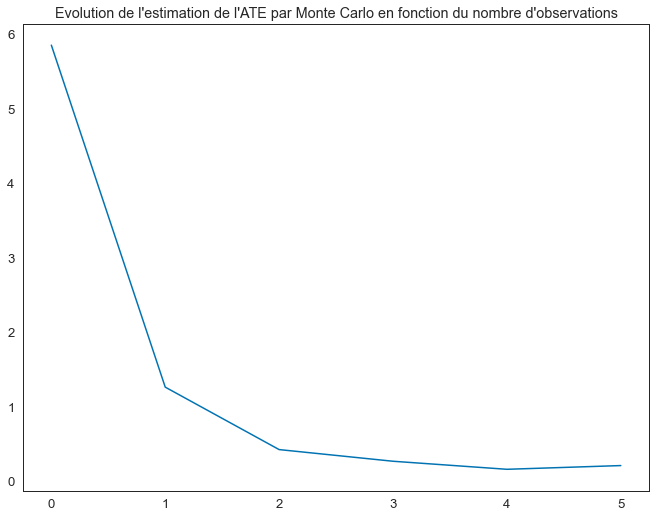

In [279]:
res = []
#1- varier Nobs pour ate_hat_S et le comparer avec mc_est (meth. monte carlo) avec 10**8
#2 - ajouter une courbe avec l'estimation avec causalml avec la borne inf et max et ate_hat_S
for i in range(2,8):
    mc_est = monte_carlo(10**i, d, beta, bias, f, g, W)
    res.append([abs(mc_est - ate_hat_S)])
plt.figure()
plt.title('Evolution de l\'estimation de l\'ATE par Monte Carlo en fonction du nombre d\'observations')
plt.plot(res);

#### Calcul des Intervalles de Confiance de l'ATE

In [280]:
def causal_generation_bootstrap(beta, bias, B= 999, Nobs =1000, dim=2, f=lambda i:i, g=lambda i:i, p=None):
    '''
    Create list of bootstrap elements
    Input :
    
    B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes, 1000 par défaut
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques 
    (features), 2 par défaut
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner 
    l'affectation du traitement.
    f et g sont des fonctions, identité par défaut
    
    Output:
    
    [(X, W, Y)] : liste de B Triplets contenant la matrice X des features, W 
    le vecteur de l'affectation du traitement et Y le vecteur des résultats 
    potentiels. 
                
    '''
    Bootstraps=[]

    for b in range(B):
        Bootstraps.append(causal_generation(Nobs, dim, beta, bias, f, g, p))
      
    return Bootstraps

In [281]:
def IC(Bootstraps, base_metalerner=SLearner(),alpha=0.05):
    
    '''
    Calculate l'intervalle de confiance d'un métalearner
    
    Input :
    
    Bootstraps : Liste d'échantillons Boostraps comprenant B triplets (X,Y,W)
    base_metalerner : metalearner à évaluer
    
    Output:
    
    IC : (IC inf , IC sup) du métalearner 
    '''
    #import
    from scipy.stats import norm
    
    #Calcul de l'ATE les B estimateurs du Bootstrap
    ATEs=np.zeros((len(Bootstraps)))
    base_metalearner=SLearner()
    for i in range(len(Bootstraps)):
        base_metalearner.fit(Bootstraps[i][0],Bootstraps[i][1],Bootstraps[i][2])
        base_metalearner.predict_CATE(Bootstraps[i][0])
        ATEs[i]=base_metalearner.predict_ATE()
    
    #Calcul des intervalles de confiance
    Mu_ATEs= ATEs.mean()
    std_ATEs= ATEs.std()
    ATEs_tilt= (ATEs-Mu_ATEs)/std_ATEs
    ATEs_tilt.sort()
    ATEs.sort()
    IC_inf, IC_sup = ATEs[int(B*(alpha/(2)))], ATEs[int(B*(1-alpha/(2)))]
    
    return (Mu_ATEs, IC_inf, IC_sup)

In [282]:
B=999
Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =N, dim=d, f=f, g=g, p=p)
IC(Bootstraps, base_metalerner=SLearner(),alpha=0.05)

(-9.988285225598343, -11.592585533301145, -8.425098651975118)

### Comparaison graphiques des résultats

In [283]:
def graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, base_learner_homemade, base_learner_causalml,title=None):

  '''
  Create a graphic to compare our bases learners vs base learners from causalml 

  Input :
    
  B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
  nb_obs : Nombre de lignes da la matrice X, les listes sont acceptables i.e. nombre de personnes, 1000 par défaut
  dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features), 2 par défaut
  beta : Vecteur de dimension (2, dim).
  bias : Vecteur de dimension (1, 2).
  W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
  f et g sont des fonctions, identité par défaut
    
  Output:
  Graphique comparant nos base_learner avec ceux du causal_ml
  '''

  ate_causal_ml = []
  lb_causal_ml = []
  ub_causal_ml = []

  ates = []
  ates_inf = []
  ates_sup = []

  for n in nb_obs:

    # Génération des données
    Bootstraps=causal_generation_bootstrap(beta, bias, B= B, Nobs =n, dim=d, f=f, g=g, p=p) 
    mu, inf, sup = IC(Bootstraps, base_metalerner=base_learner_homemade, alpha=0.05)
    ates.append(mu)
    ates_inf.append(inf)
    ates_sup.append(sup)

    # S learner causal ML
    X, W, Y = causal_generation(n, d, beta, bias, f, g, p)
    lr = base_learner_causalml
    te, lb, ub = lr.estimate_ate(X, W, Y)
    ate_causal_ml.append(te[0])
    lb_causal_ml.append(lb[0])
    ub_causal_ml.append(ub[0])


  plt.plot(nb_obs,ates, color='blue',label = 'ATE_homemade')
  plt.fill_between(nb_obs, ates_inf,ates_sup,alpha = 0.5, color='blue', label = 'IC_ATE_homemade')
  plt.plot(nb_obs, ate_causal_ml,color='orange',label='ATE_causal_ml')
  plt.fill_between(nb_obs, lb_causal_ml, ub_causal_ml,alpha = 0.5, color='orange',label='IC_ATE_causalml')
  plt.legend()
  plt.show()
  

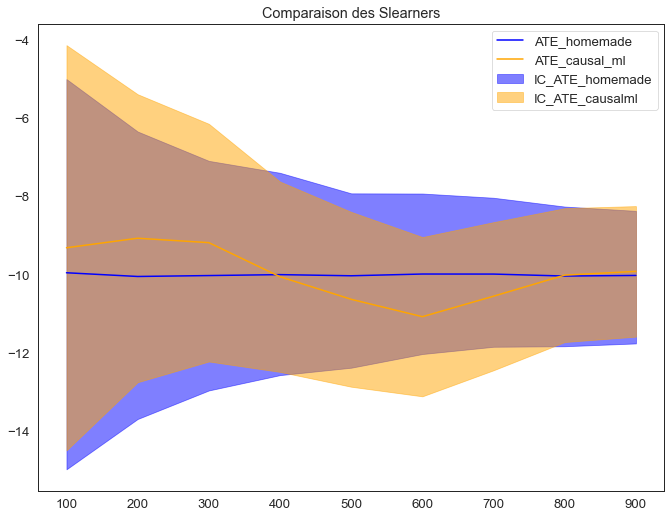

In [284]:
nb_obs = [i for i in range(100,1000,100)]
plt.title('Comparaison des Slearners');
graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, SLearner(), LRSRegressor())

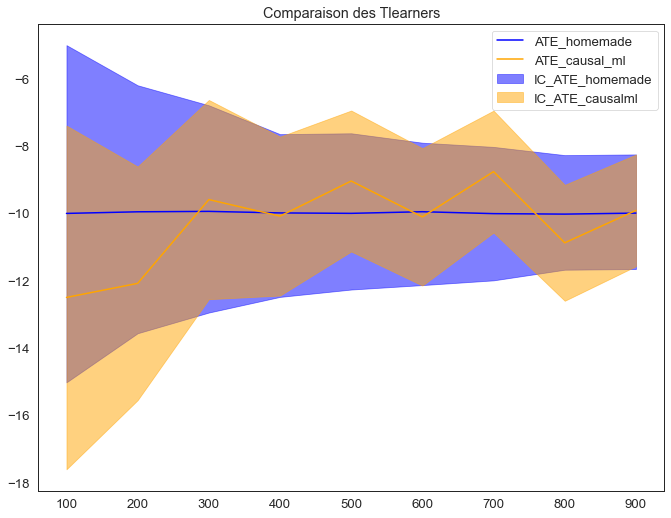

In [285]:
nb_obs = [i for i in range(100,1000,100)]
plt.title('Comparaison des Tlearners');
graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, TLearner(), XGBTRegressor())

# Test sur clustering

In [80]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor
import tp_knn_source

In [137]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 500
d = 2                                     # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.5
beta0 = np.random.uniform(1, 30, (1, d))
beta1 = np.random.uniform(1, 100, (1, d))
beta = np.vstack((beta0,beta0))               # beta0 = beta1           
bias = np.array([0,10])                       # Gamma0 = Gamma1 
f = lambda x:x
g = lambda x:x

In [262]:
def causal_generation_bigauss(Nobs, dim, beta, bias, f, g, p):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner 
    l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, Y, W) : Triplet contenant la matrice X des features, Y le vecteur des 
                résultats potentiels et W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    n1 = int(Nobs/2)
    n2 = Nobs-n1
    X, _= tp_knn_source.rand_bi_gauss(n1=n1, n2=n2, mu1=[1, 1], mu2=[0.5, 0.5], sigmas1=[0.5, 0.1],
                  sigmas2=[0.1, 0.1])
    
    Y = np.zeros(Nobs)

    W = treatment_assign(Nobs, dim, X, p)

    for i in range(Nobs):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

In [263]:
# Génération des données
X, W, Y = causal_generation_bigauss(N, d, beta, bias, f, g, p)

## Clustering sur les features

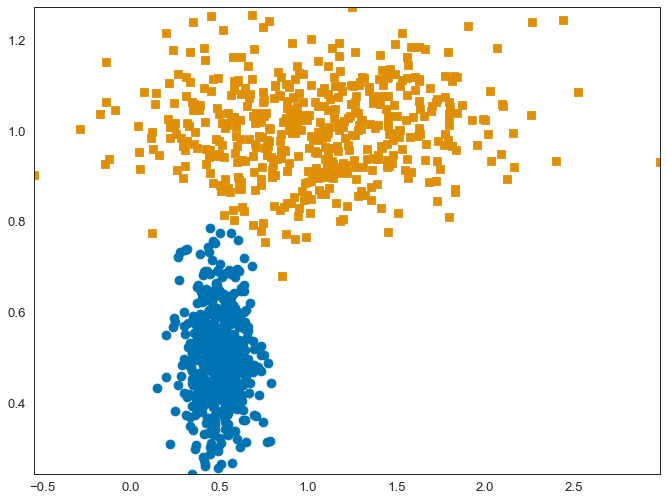

In [264]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X)
groups=gmm.predict(X)
#Plot
data=[X, groups]
tp_knn_source.plot_2d(data[0],data[1])

In [265]:
slearner=SLearner(base_estimator=RandomForestRegressor())
slearner.fit(X,W,Y)

labels=np.unique(groups)
idx_group0=groups==labels[0]
idx_group1=groups==labels[1]

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE pour le groupe complet= {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE pour le groupe complet= {}.".format(ate_hat_S))

cate_hat_S0 = slearner.predict_CATE(X[idx_group0])
print("- Les dimensions du CATE pour le groupe 0 = {}.".format(cate_hat_S0.shape))

ate_hat_S0 = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE pour le groupe 0= {}.".format(ate_hat_S0))

cate_hat_S1 = slearner.predict_CATE(X[idx_group1])
print("- Les dimensions du CATE pour le groupe 1 = {}.".format(cate_hat_S1.shape))

ate_hat_S1 = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE pour le groupe 1= {}.".format(ate_hat_S1))

- Les dimensions du CATE pour le groupe complet= (1000,).
- L'estimation de la valeur de l'ATE pour le groupe complet= -42.420067570565635.
- Les dimensions du CATE pour le groupe 0 = (502,).
- L'estimation de la valeur de l'ATE pour le groupe 0= -31.45120858661964.
- Les dimensions du CATE pour le groupe 1 = (498,).
- L'estimation de la valeur de l'ATE pour le groupe 1= -53.47702983952324.


## Clustering sur le CATE

In [266]:
CATE=cate_hat_S.reshape(-1, 1)
gmm = GaussianMixture(n_components=2)
gmm.fit(CATE)
groups=gmm.predict(CATE)

In [267]:
labels=np.unique(groups)
idx_group0=groups==labels[0]
idx_group1=groups==labels[1]

In [268]:
print("- Les dimensions du CATE pour le groupe complet = {}.".format(cate_hat_S.shape))
print("- L'estimation de la valeur de l'ATE pour le groupe complet= {}.".format(cate_hat_S.mean()))
print("- Les dimensions du CATE pour le groupe 0 = {}.".format(cate_hat_S[idx_group0].shape))
print("- L'estimation de la valeur de l'ATE pour le groupe 0= {}.".format(cate_hat_S[idx_group0].mean()))
print("- Les dimensions du CATE pour le groupe 1 = {}.".format(cate_hat_S[idx_group1].shape))
print("- L'estimation de la valeur de l'ATE pour le groupe 1= {}.".format(cate_hat_S[idx_group1].mean()))

- Les dimensions du CATE pour le groupe complet = (1000,).
- L'estimation de la valeur de l'ATE pour le groupe complet= -42.420067570565635.
- Les dimensions du CATE pour le groupe 0 = (521,).
- L'estimation de la valeur de l'ATE pour le groupe 0= -31.62497481111138.
- Les dimensions du CATE pour le groupe 1 = (479,).
- L'estimation de la valeur de l'ATE pour le groupe 1= -54.16170291018081.
